# Tests! (does my code work?)

## Test construtors in POMDP

In [494]:
using Plots
using Distributions
using Statistics
theme(:solarized)

In [495]:
include("POMDPs.jl")

Main.POMDPs

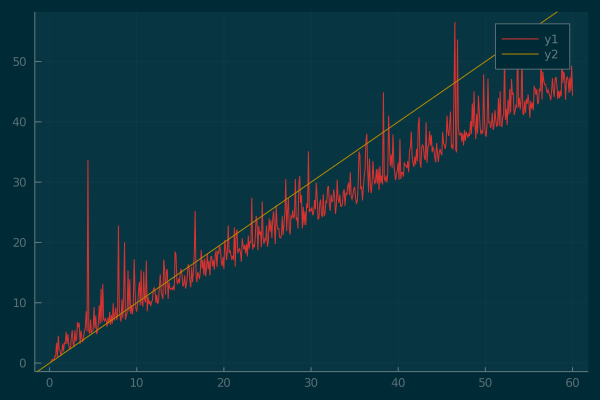

In [496]:
include("Examples.jl")
function T!(x,f)
    Examples.partiallyObservedFishery_T!(x,f,Examples.partiallyObservedFishery_pars)
end
R = (x,f) -> Examples.partiallyObservedFishery_R!(x,f,Examples.partiallyObservedFishery_pars)
G = (y,x,f) -> Examples.partiallyObservedFishery_G(x,y,f,Examples.partiallyObservedFishery_pars)
G_sim = (x,f) -> Examples.partiallyObservedFishery_G_sim(x,f,Examples.partiallyObservedFishery_pars)
delta = 0.93
partiallyObservableFishery = POMDPs.init(T!, R, G_sim, G, delta,1, [[1.0]])

x = log.(0.1:0.1:60)
x_copy = log.(0.1:0.1:60)
y = broadcast(x -> partiallyObservableFishery.T!([x], [0.0])[1] ,x)
Plots.plot(exp.(x_copy),exp.(y) )
Plots.abline!(1,0)

# Test `ParticleFilters.jl`
To start use base methods for patially observed systems

In [497]:
include("ParticleFilters.jl")

Main.ParticleFilters

## Initalize a particle filter object

In [498]:

PF = ParticleFilters.init(500,1) # generate particle filter object
prior = Distributions.Normal(3.5,0.5) # set prior distribution
broadcast(i -> PF.samples[i] .= rand(prior,1)[1], 1:PF.N) # sample from prior
print(" ")

Initalizing a standard particle filter 

# Generate a time series of observaitons 

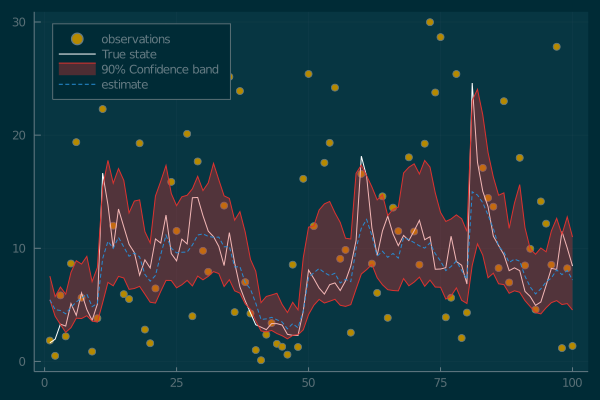

In [499]:
x = [0.5]
t_ = 100
yt = broadcast(i -> zeros(2),1:t_)
xt = zeros(t_)
for t in 1:t_
    xt[t] = x[1]
    yt[t] .= partiallyObservableFishery.G_sim(x,[0.1])
    partiallyObservableFishery.T!(x, [0.1])
end 
# plot observations and true abundnaces 
p1 = Plots.scatter(broadcast(i -> exp(yt[i][1]),1:t_), color = 2, ylim = [0,30], label = "observations")
p1 = Plots.plot!(p1, exp.(xt), color = "white", label = "True state")

x_hat, x_lower, x_upper = zeros(t_), zeros(t_), zeros(t_)
for t in 1:t_
    ParticleFilters.bayesUpdate!(PF,partiallyObservableFishery.G,yt[t],[0.1])
    ParticleFilters.resample!(PF)
    x_hat[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.05)
    x_upper[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.95)
    ParticleFilters.timeUpdate!(PF,partiallyObservableFishery.T!,[0.1])
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")
p1 = Plots.plot!(p1, exp.(x_hat), c = 3, linestyle =:dash, label = "estimate")
p1

# Test unscented Kalman Filters

## Initailize `POMDP_KalmanFilter`

In [524]:
# load KalmandFilters.jl and Examples.jl
using KalmanFilters
include("Examples.jl")
include("POMDPs.jl")
# initianize POMDP object
T_! = (x,f) -> Examples.unknownGrowthRate_T!(x,f,(0.2,0.1))
T_ = (x,f) -> Examples.unknownGrowthRate_T(x,f,(0.2,0.1))
R = (x,f) -> sum(x)
Sigma_N = Examples.Sigma_N
H = (x,a) -> Examples.H * x
Sigma_O = reshape(Examples.Sigma_O,1,1)
delta = 0.95
unknownGrowthRate = POMDPs.init(T_!,T_,R,H,Sigma_N,Sigma_O,delta, 1)
print(" ")

## Comapre Particle filter and Kalman filter resutls

Initalizing a standard particle filter 

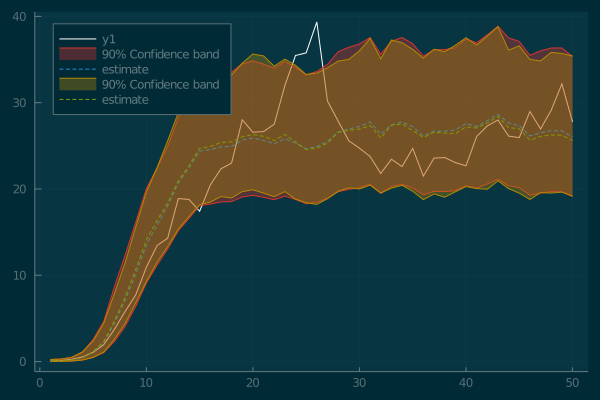

In [525]:

#### generate time series ####
N_ = 50
yt = zeros(N_)
xt = zeros(N_)
x = [-3.5,1.5]
for t in 1:N_
    x = unknownGrowthRate.T_sim!(x,[0.1])
    xt[t] = x[1]
    yt[t] = unknownGrowthRate.G_sim(x,[0.1])[1]
end 
#p1 = Plots.scatter(exp.(yt), c=1)
p1 = Plots.plot(exp.(xt), color = "white")
p1


#### initalize filters ####
# prior distribution 
x0, P0 = [-3.5,1.5],[1.0 0.0; 0.0 0.0025]

# init particle filter
PF = ParticleFilters.init(5000,2) # generate particle filter object
prior = Distributions.MvNormal(x0,P0) # set prior distribution
broadcast(i -> PF.samples[i] .= reshape(rand(prior,1),2), 1:PF.N) # sample from prior

# step 1 to init KalmanFilter object
uKF = KalmanFilters.time_update(x0,P0,
                    x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)

uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[1],
                    x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)

# update Particle Filter
ParticleFilters.timeUpdate!(PF,unknownGrowthRate.T_sim!,[0.1])
ParticleFilters.bayesUpdate!(PF,unknownGrowthRate.G,yt[1],[0.1])
ParticleFilters.resample!(PF)
print(" ")


x = get_state(uKF)
P = get_covariance(uKF)

### accumulators ###

# kalman filter
x_hat = zeros(N_)
a_hat = zeros(N_)
x_lower, x_upper = zeros(N_),zeros(N_)
a_lower, a_upper = zeros(N_),zeros(N_)

x_hat[1] = x[1]
a_hat[1] = x[2]

x_lower[1], x_upper[1] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
a_lower[1], a_upper[1] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])

# particle filter
x_hat_pf = zeros(N_)
a_hat_pf = zeros(N_)
x_lower_pf, x_upper_pf = zeros(N_),zeros(N_)
a_lower_pf, a_upper_pf = zeros(N_),zeros(N_)

x_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
a_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)

x_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
x_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
a_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
a_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)

#### iterate ove time series ####
for t in 2:N_
    # update Kalman Filter
    uKF = KalmanFilters.time_update(get_state(uKF),get_covariance(uKF),
                        x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)
    
    uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[t],
                           x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)
    
    
    # update Particle Filter
    ParticleFilters.timeUpdate!(PF,unknownGrowthRate.T_sim!,[0.1])
    ParticleFilters.bayesUpdate!(PF,unknownGrowthRate.G,yt[t],[0.1])
    ParticleFilters.resample!(PF)
    
    
    
    x = get_state(uKF)
    P = get_covariance(uKF)
    x_hat[t] = x[1]
    a_hat[t] = x[2]

    x_lower[t], x_upper[t] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
    a_lower[t], a_upper[t] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])
    
    # particel filter data     
    x_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
    x_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
    
    
    a_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)
    a_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
    a_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")
p1 = Plots.plot!(p1, exp.(x_hat), c = 3, linestyle =:dash, label = "estimate")

p1 = Plots.plot!(p1,exp.(x_lower_pf), fillrange = exp.(x_upper_pf), 
    fillalpha = 0.35,  c = 2,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper_pf), c=2, label = "")
p1 = Plots.plot!(p1, exp.(x_hat_pf), c = 4, linestyle =:dash, label = "estimate")


p1

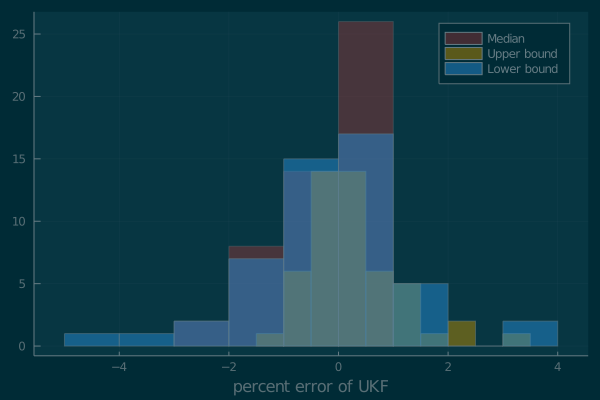

In [526]:
Plots.histogram(100 *(x_hat .- x_hat_pf)./mean(x_hat_pf),
    xlab = "percent error of UKF", label = "Median", alpha = 0.3)
Plots.histogram!(100 *(x_upper .- x_upper_pf)./mean(x_upper_pf), 
    label = "Upper bound", alpha = 0.5)
Plots.histogram!(100 *(x_lower .- x_lower_pf)./mean(x_lower_pf), 
    label = "Lower bound", alpha = 0.5)

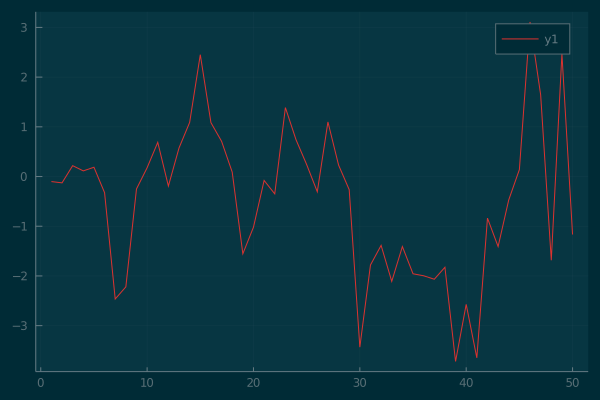

In [461]:
mean(exp.(x_hat_pf))

39.82624005777746

In [468]:
a = POMDPs.discreteActions{AbstractVector{Float64}}(2, [[1.0],[0.0]])

Main.POMDPs.discreteActions{AbstractArray{Float64,1}}(2, AbstractArray{Float64,1}[[1.0], [0.0]])

In [469]:
a.actions

2-element Array{AbstractArray{Float64,1},1}:
 [1.0]
 [0.0]